In [1]:
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('/raven/u/ajagadish/vanilla-llama/categorisation/')
sys.path.append('/raven/u/ajagadish/vanilla-llama/categorisation/data')
sys.path.append('/raven/u/ajagadish/vanilla-llama/categorisation/rl2')
import torch
from model import RL2, MetaLearner
import torch.nn.utils.rnn as rnn_utils
import numpy as np

In [8]:
data = pd.read_csv('../data/human/exp1_llm.csv')

In [12]:
data

,participant,task,trial,choice,correct_choice,reward,block,condition,category,object,all_features,feature1,feature2,feature3,llm_category
0,0,0,0,j,j,1.0,0,1,1,Big Black Square,"[1, 1, 1]",1,1,1,A
1,0,0,1,j,f,-1.0,0,1,0,Small Black Triangle,"[0, 1, 0]",0,1,0,B
2,0,0,2,f,j,-1.0,0,1,1,Big White Triangle,"[1, 0, 0]",1,0,0,A
3,0,0,3,f,f,1.0,0,1,0,Small White Triangle,"[0, 0, 0]",0,0,0,B
4,0,0,4,f,f,1.0,0,1,0,Small White Square,"[0, 0, 1]",0,0,1,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33435,94,0,331,f,f,1.0,3,1,0,Big White Triangle,"[1, 0, 0]",1,0,0,NaN
33436,94,0,332,j,j,1.0,3,1,1,Small Black Triangle,"[0, 1, 0]",0,1,0,NaN
33437,94,0,333,j,j,1.0,3,1,1,Small Black Square,"[0, 1, 1]",0,1,1,NaN
33438,94,0,334,f,f,1.0,3,1,0,Small White Triangle,"[0, 0, 0]",0,0,0,NaN


In [27]:
# Reload the dataset
data = pd.read_csv('Badham_Sanborn_Maylor_2017_aggregate_data.csv')

# Define columns
block_acc_columns = ["TYPEONE_BLK_ACC_1", "TYPEONE_BLK_ACC_2", "TYPEONE_BLK_ACC_3", 
                     "TYPEONE_BLK_ACC_4", "TYPEONE_BLK_ACC_5", "TYPEONE_BLK_ACC_6"]

block_acc_columns_type2 = ["TYPETWO_BLK_ACC_1", "TYPETWO_BLK_ACC_2", "TYPETWO_BLK_ACC_3", 
                           "TYPETWO_BLK_ACC_4", "TYPETWO_BLK_ACC_5", "TYPETWO_BLK_ACC_6"]

block_acc_columns_type3 = ["TYPETHREE_BLK_ACC_1", "TYPETHREE_BLK_ACC_2", "TYPETHREE_BLK_ACC_3", 
                           "TYPETHREE_BLK_ACC_4", "TYPETHREE_BLK_ACC_5", "TYPETHREE_BLK_ACC_6"]

block_acc_columns_type4 = ["TYPEFOUR_BLK_ACC_1", "TYPEFOUR_BLK_ACC_2", "TYPEFOUR_BLK_ACC_3", 
                           "TYPEFOUR_BLK_ACC_4", "TYPEFOUR_BLK_ACC_5", "TYPEFOUR_BLK_ACC_6"]

# Split the dataset into two groups based on the age
data_younger = data[data['AGE_Y1_O0']==1] #data[data["AGE"] <= 41]
data_older = data[data['AGE_Y1_O0']==0] #data[data["AGE"] > 41]

# Calculate the mean accuracy over participants for each block for all four types for the younger group
mean_accuracy_younger_type1 = data_younger[block_acc_columns].mean()
mean_accuracy_younger_type2 = data_younger[block_acc_columns_type2].mean()
mean_accuracy_younger_type3 = data_younger[block_acc_columns_type3].mean()
mean_accuracy_younger_type4 = data_younger[block_acc_columns_type4].mean()

# Calculate the mean accuracy over participants for each block for all four types for the older group
mean_accuracy_older_type1 = data_older[block_acc_columns].mean()
mean_accuracy_older_type2 = data_older[block_acc_columns_type2].mean()
mean_accuracy_older_type3 = data_older[block_acc_columns_type3].mean()
mean_accuracy_older_type4 = data_older[block_acc_columns_type4].mean()

# Calculate the mean difference in task performance between old and young groups for the four types
mean_difference_type1 = mean_accuracy_younger_type1.mean() - mean_accuracy_older_type1.mean()
mean_difference_type2 = mean_accuracy_younger_type2.mean() - mean_accuracy_older_type2.mean()
mean_difference_type3 = mean_accuracy_younger_type3.mean() - mean_accuracy_older_type3.mean()
mean_difference_type4 = mean_accuracy_younger_type4.mean() - mean_accuracy_older_type4.mean()

mean_differences = [mean_difference_type1, mean_difference_type2, mean_difference_type3, mean_difference_type4]

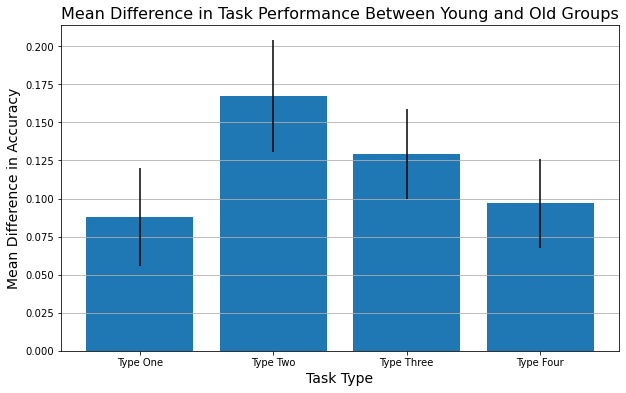

In [28]:
# Calculate the standard error of the mean accuracy for each block for all four types for the younger group
sem_accuracy_younger_type1 = data_younger[block_acc_columns].sem()
sem_accuracy_younger_type2 = data_younger[block_acc_columns_type2].sem()
sem_accuracy_younger_type3 = data_younger[block_acc_columns_type3].sem()
sem_accuracy_younger_type4 = data_younger[block_acc_columns_type4].sem()

# Calculate the standard error of the mean accuracy for each block for all four types for the older group
sem_accuracy_older_type1 = data_older[block_acc_columns].sem()
sem_accuracy_older_type2 = data_older[block_acc_columns_type2].sem()
sem_accuracy_older_type3 = data_older[block_acc_columns_type3].sem()
sem_accuracy_older_type4 = data_older[block_acc_columns_type4].sem()

# Calculate the standard error of the mean difference in task performance between old and young groups for the four types
sem_difference_type1 = ((sem_accuracy_younger_type1**2 + sem_accuracy_older_type1**2)**0.5).mean()
sem_difference_type2 = ((sem_accuracy_younger_type2**2 + sem_accuracy_older_type2**2)**0.5).mean()
sem_difference_type3 = ((sem_accuracy_younger_type3**2 + sem_accuracy_older_type3**2)**0.5).mean()
sem_difference_type4 = ((sem_accuracy_younger_type4**2 + sem_accuracy_older_type4**2)**0.5).mean()

sem_differences = [sem_difference_type1, sem_difference_type2, sem_difference_type3, sem_difference_type4]

# Create bar plot with error bars
plt.figure(figsize=(10,6))
plt.bar(range(1,5), mean_differences, yerr=sem_differences, tick_label=["Type One", "Type Two", "Type Three", "Type Four"])
plt.title("Mean Difference in Task Performance Between Young and Old Groups", fontsize=16)
plt.xlabel("Task Type", fontsize=14)
plt.ylabel("Mean Difference in Accuracy", fontsize=14)
plt.grid(axis='y')
plt.show()

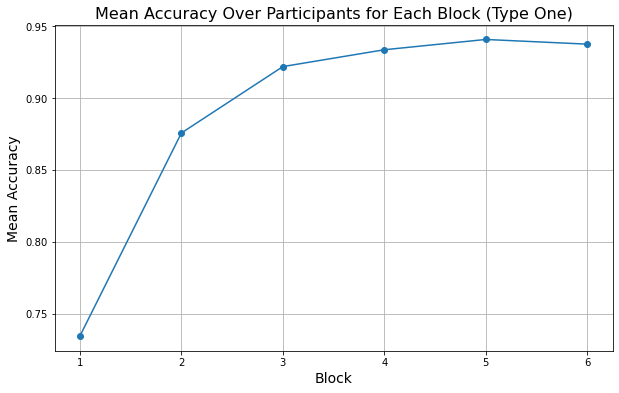

In [29]:
# Extract the columns related to the mean accuracy over the 6 blocks for Type One
block_acc_columns = ["TYPEONE_BLK_ACC_1", "TYPEONE_BLK_ACC_2", "TYPEONE_BLK_ACC_3", 
                     "TYPEONE_BLK_ACC_4", "TYPEONE_BLK_ACC_5", "TYPEONE_BLK_ACC_6"]

# Calculate the mean accuracy over participants for each block
mean_accuracy = data[block_acc_columns].mean()

# Plot
plt.figure(figsize=(10,6))
plt.plot(range(1,7), mean_accuracy, marker='o')
plt.title("Mean Accuracy Over Participants for Each Block (Type One)", fontsize=16)
plt.xlabel("Block", fontsize=14)
plt.ylabel("Mean Accuracy", fontsize=14)
plt.grid(True)
plt.xticks(range(1,7))
plt.show()

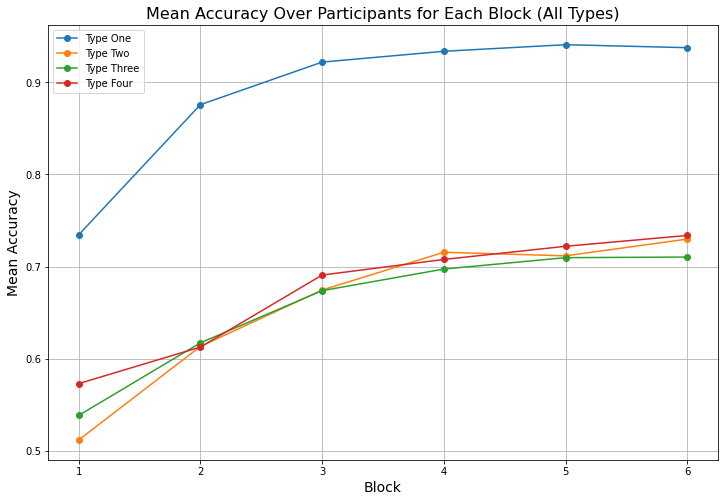

In [23]:
# Extract the columns related to the mean accuracy over the 6 blocks for all four types
block_acc_columns_type2 = ["TYPETWO_BLK_ACC_1", "TYPETWO_BLK_ACC_2", "TYPETWO_BLK_ACC_3", 
                           "TYPETWO_BLK_ACC_4", "TYPETWO_BLK_ACC_5", "TYPETWO_BLK_ACC_6"]

block_acc_columns_type3 = ["TYPETHREE_BLK_ACC_1", "TYPETHREE_BLK_ACC_2", "TYPETHREE_BLK_ACC_3", 
                           "TYPETHREE_BLK_ACC_4", "TYPETHREE_BLK_ACC_5", "TYPETHREE_BLK_ACC_6"]

block_acc_columns_type4 = ["TYPEFOUR_BLK_ACC_1", "TYPEFOUR_BLK_ACC_2", "TYPEFOUR_BLK_ACC_3", 
                           "TYPEFOUR_BLK_ACC_4", "TYPEFOUR_BLK_ACC_5", "TYPEFOUR_BLK_ACC_6"]

# Calculate the mean accuracy over participants for each block for all four types
mean_accuracy_type2 = data[block_acc_columns_type2].mean()
mean_accuracy_type3 = data[block_acc_columns_type3].mean()
mean_accuracy_type4 = data[block_acc_columns_type4].mean()

# Plot
plt.figure(figsize=(12,8))
plt.plot(range(1,7), mean_accuracy, marker='o', label="Type One")
plt.plot(range(1,7), mean_accuracy_type2, marker='o', label="Type Two")
plt.plot(range(1,7), mean_accuracy_type3, marker='o', label="Type Three")
plt.plot(range(1,7), mean_accuracy_type4, marker='o', label="Type Four")
plt.title("Mean Accuracy Over Participants for Each Block (All Types)", fontsize=16)
plt.xlabel("Block", fontsize=14)
plt.ylabel("Mean Accuracy", fontsize=14)
plt.grid(True)
plt.xticks(range(1,7))
plt.legend()
plt.show()

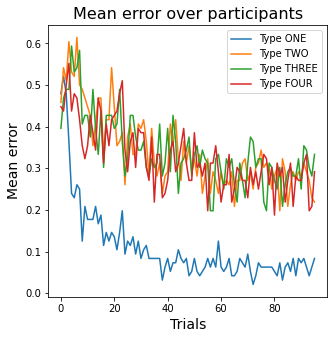

In [59]:
TYPES = ['ONE', 'TWO', 'THREE', 'FOUR']
NUM_TRIALS = 96
types_acc = [[f'TYPE{TYPE}_ACC_{idx}' for idx in range(1, NUM_TRIALS+1)] for TYPE in TYPES]

plt.figure(figsize=(5,5))
for type_name, type_acc in zip(TYPES, types_acc):
    plt.plot(np.arange(NUM_TRIALS), 1-data[type_acc].mean(), label=f'Type {type_name}')
plt.title("Mean error over participants", fontsize=16)
plt.xlabel("Trials", fontsize=14)
plt.ylabel("Mean error", fontsize=14)
plt.legend()
plt.show()